# Ichimoku Cloud Study
## Random Forrest

I want to predict price movements of stock given certain Ichimoku cloud signals are known to be present.

### Features
#### Existing
1. ~~open~~
2. ~~high~~
3. ~~low~~
4. ~~close~~
5. ~~volume~~ (TODO: Make relative)
6. ~~dividend amount~~ ( TODO: Make relative)

#### Technical Indicators
1. ~~tenken_sen~~ (replaced with close_diff_tenkan_sen_percent)
2. ~~kijun_sen~~ (replaced with close_diff_kijun_sen_percent)
3. ~~senkou_span_a~~ (replaced with close_diff_senkou_span_a_percent)
4. ~~senkou_span_b~~ (replaced with close_diff_senkou_span_b_percent)
5. ~~chikou_span~~ (forward bias)
6. RSI (period = 14 day)
7. RMI (time_period = 14 day, momentum_period = 5 day)
8. MFI (period = 14 day)
9. MACD Hist (fastperiod = 12 day, slowperiod = 26 day, signalperiod = 9 day)
10. Rel. SPY (NEED)

#### Engineered
1. close_diff_tenkan_sen_percent
2. close_diff_kijun_sen_percent
3. close_diff_senkou_span_a_percent
4. close_diff_senkou_span_b_percent
5. days_since_earnings
6. crossover_difference
7. crossover_indicator
8. close_price_diff_1_day
9. close_to_52_week_high
10. close_to_52_week_low
11. close_to_8_week_high
12. close_to_8_week_low

### Issues
- RandomForestRegressor only predicts positive targets.

In [1]:
import datetime
import numpy as np
import pandas as pd
import pytz
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor
from statsmodels.tsa.stattools import adfuller
import talib

from tools.pattern_helper import convert_to_polarity, calculate_rmi

import importlib

# After updating the package
import tools.machine_learning_helper
importlib.reload(tools.machine_learning_helper)
from tools.machine_learning_helper import find_first_below_threshold
from tools.data_helper import days_since_earnings
from sklearn.metrics import mean_squared_log_error, mean_squared_error
# TECH DEBT: determine which symbols have high accuracy...

### Load data

In [2]:
data_path = '../../../res/data/s_and_p_data.h5'
earnings_path = '../../../res/data/s_and_p_events.h5'
with pd.HDFStore(data_path) as store:
    # List all the keys/DataFrames
    dataframe_keys = store.keys()

### Earnings Dates

### Feature Engineering

In [4]:
days_into_future = 10
df_dict = {}
for key in dataframe_keys:
    df = pd.read_hdf(data_path, key)
    # convert time to eastern and end of trading day (4 PM EST, ignore early trading day)
    utc_time = pd.Series(df.index).apply(pytz.utc.localize)
    eastern = pytz.timezone('US/Eastern')
    eastern_time = utc_time.apply(lambda x: x.astimezone(eastern))
    new_time = datetime.time(16, 0, 0)  # Setting time to 16:00:00
    df.index = eastern_time.apply(lambda x: x.replace(hour=new_time.hour, minute=new_time.minute, second=new_time.second))
    
    # tech debt: perform this conversion when saving events to h5
    # get earnings dates
    events_df = pd.read_hdf(earnings_path, key)
    earnings_dates = events_df.loc[events_df['eventType'] == 'chartEvent/earnings', 'dateTimestamp']
    # Make it timezone aware
    utc_time = earnings_dates.apply(pytz.utc.localize)
    # Eastern timezone
    eastern = pytz.timezone('US/Eastern')
    # Convert to Eastern Time
    earnings_dates_eastern_time = utc_time.apply(lambda x: x.astimezone(eastern))

    # # drop data before earliest earnings date 
    # df = df[df.index >= earnings_dates_eastern_time.min()]
    # tech debt: change to days UNTIL earnings. Requires alpha vantage to get date. Need solution for when date is unknown...
    # Apply the function to each date in df
    df['days_since_earnings'] = df.index.map(lambda date: days_since_earnings(date, earnings_dates_eastern_time))
    
    
    df['rsi'] = talib.RSI(df['close'], timeperiod=14)
    df['mfi'] = talib.MFI(high=df['high'], low=df['low'], close=df['close'], volume=df['volume'], timeperiod=14)
    df['rmi'] = calculate_rmi(df['close'], time_period=14, momentum_period=5)
    
    macd = talib.MACD(
        df['close'], fastperiod=12, slowperiod=26, signalperiod=9)
    
    df['macd_hist'] = macd[2]
    df['close_price_diff_1_day'] = df['close'].pct_change()
    
    df.loc[:, 'crossover_difference'] = df['tenkan_sen'] - df['kijun_sen']
    # -1 when crossover occurs, 1 when no change of sign, otherwise 0 if crossover_difference is 0
    df.loc[:, 'crossover_indicator'] = (
        (df['crossover_difference'] * df['crossover_difference'].shift(1)).apply(
            convert_to_polarity))
    
    # Calculate the 52-week high for each date
    # Compute the current close relative to the 52-week high
    df['close_to_52_week_high'] = df['close'] / df['close'].rolling(window='365D').max()
    # Calculate the 52-week low for each date
    # Compute the current close relative to the 52-week low
    df['close_to_52_week_low'] = df['close'] / df['close'].rolling(window='365D').min()
    
    df['close_to_8_week_high'] = df['close'] / df['close'].rolling(window='56D').max()
    df['close_to_8_week_low'] = df['close'] / df['close'].rolling(window='56D').min()

    
    target_col = f'highest_close_next_{days_into_future}_days_percent'
    # df.loc[:, target_col] = df['close'].pct_change(offset)
    df[target_col] = (
        df['close'].shift(-days_into_future).rolling(window=days_into_future, min_periods=days_into_future).max() - df['close']
    ) / df['close']
    
    df.loc[:, 'close_diff_tenkan_sen_percent'] = (df['close'] - df['tenkan_sen']) / df['tenkan_sen']
    df.loc[:, 'close_diff_kijun_sen_percent'] = (df['close'] - df['kijun_sen']) / df['kijun_sen']
    df.loc[:, 'close_diff_senkou_span_a_percent'] = (df['close'] - df['senkou_span_a']) / df['senkou_span_a']
    df.loc[:, 'close_diff_senkou_span_b_percent'] = (df['close'] - df['senkou_span_b']) / df['senkou_span_b']
    
    # Introduce seasonality
    
    df.loc[:, 'month'] = df.index.month

    # Todo: introduce days since earnings...or days until earnings...
    
    df = df.dropna(subset=[target_col]).copy()
    if df.shape[0] > 0:
        # Check if p-value is <= 0.05 to confirm stationary series
        result = adfuller(df[target_col])
    else:
        continue
    if result[1] < 0.05:
        ### Train when buliish crossover signal is present
        # If crossover_indicator == -1
        # and crossover_difference > 0
        # and signal closes above cloud
        # then LONG signal
        
        long_idx = ((df['crossover_indicator'] == -1) & (df['crossover_difference'] > 0) & 
                    (df['close_diff_senkou_span_a_percent'] > 0) & (df['close_diff_senkou_span_b_percent'] > 0))
        
        # If crossover_indicator == -1
        # and crossover_difference < 0
        # and signal closes below cloud
        # then SHORT signal
        
        short_idx = ((df['crossover_indicator'] == -1) & (df['crossover_difference'] < 0) & 
                    (df['close_diff_senkou_span_a_percent'] < 0) & (df['close_diff_senkou_span_b_percent'] < 0))
        
        # df.loc[:, 'target'] = 'NONE'
        # df.loc[long_idx, 'target'] = 'LONG'
        # df.loc[short_idx, 'target'] = 'SHORT'
        df = df.loc[long_idx].copy()
        df.drop(['open', 'high', 'low', 'close', 'volume', 'dividend_amount',
                 'tenkan_sen', 'kijun_sen', 'senkou_span_a', 'senkou_span_b',
                 'chikou_span', # not a known value in real-time.
                 ], axis=1, inplace=True)
        df_dict[key] = df.dropna(subset=[
            'close_price_diff_1_day', 'crossover_indicator',
            'close_diff_tenkan_sen_percent', 'close_diff_kijun_sen_percent',
            'close_diff_senkou_span_a_percent', 'close_diff_senkou_span_b_percent', 'rsi', 'rmi', 'mfi', 'macd_hist', 'days_since_earnings', 
            'close_to_52_week_high', 'close_to_52_week_low',
            'close_to_8_week_high', 'close_to_8_week_low',
            target_col,
        ]).copy()
    else:
        print('p-value: %f' % result[1])
        print(f"Dropped {key} because it did not pass the stationary series test")
    


p-value: 0.759851
Dropped /VLTO because it did not pass the stationary series test


In [48]:
# TECH DEBT: optimize hyperparameter
n_features_to_select = 20
test_length = 2
min_date = pd.Timestamp('2010-10-01 16:00:00', tz='US/Eastern')
final_df_test_x_list = []
final_df_test_y_list = []
final_df_train_x_list = []
final_df_train_y_list = []
for key, df in df_dict.items():
    final_df = df.loc[df.index >= min_date]
    final_df = final_df.reset_index(drop=True)
    
    end_point = len(final_df)
    x = end_point - test_length
    final_df_train = final_df.loc[:x - 1, :]
    final_df_test = final_df.loc[x:, :]
    
    final_df_test_x_list.append(final_df_test.loc[:, [col for col in final_df_test.columns if col not in [target_col]]])
    final_df_test_y_list.append(final_df_test[target_col])
    final_df_train_x_list.append(final_df_train.loc[:, [col for col in final_df_test.columns if col not in [target_col]]])
    final_df_train_y_list.append(final_df_train[target_col])
    
final_df_test_x = pd.concat(final_df_test_x_list)
final_df_test_y = pd.concat(final_df_test_y_list)
final_df_train_x = pd.concat(final_df_train_x_list)
final_df_train_y = pd.concat(final_df_train_y_list)


In [49]:
print("Starting model train..")
rfe = RFE(RandomForestRegressor(n_estimators=100, random_state=1), n_features_to_select=n_features_to_select)
fit = rfe.fit(final_df_train_x, final_df_train_y)
y_pred = fit.predict(final_df_test_x)

Starting model train..


In [50]:

y_true = final_df_test_y.values

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
rmse

0.03897178786974167

In [51]:
# Get the mask of the selected features
selected_features_mask = rfe.support_

# Get the rankings of the features
feature_ranking = rfe.ranking_

# Get the names of the selected features
selected_features = final_df_train_x.columns[selected_features_mask]

print("Selected features:", list(selected_features))
print("Feature ranking:", feature_ranking)

Selected features: ['days_since_earnings', 'rsi', 'mfi', 'rmi', 'macd_hist', 'close_price_diff_1_day', 'crossover_difference', 'crossover_indicator', 'close_to_52_week_high', 'close_to_52_week_low', 'close_to_8_week_high', 'close_to_8_week_low', 'close_diff_tenkan_sen_percent', 'close_diff_kijun_sen_percent', 'close_diff_senkou_span_a_percent', 'close_diff_senkou_span_b_percent', 'month']
Feature ranking: [1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1]


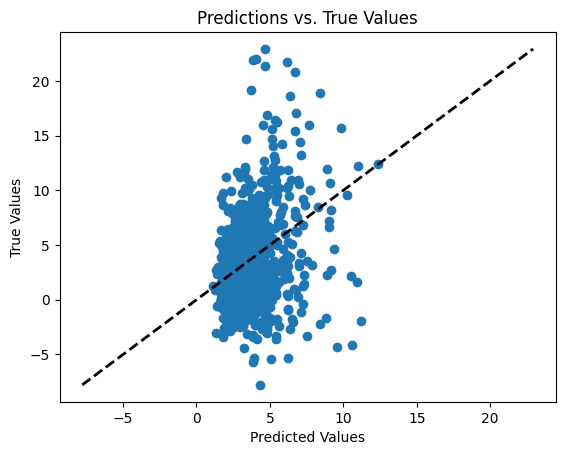

In [52]:
import matplotlib.pyplot as plt
# Optionally, add a line for perfect correlation for reference
actual_values = y_true * 100
predicted_values = y_pred * 100
plt.scatter(predicted_values, actual_values)
plt.plot([actual_values.min(), actual_values.max()], [actual_values.min(), actual_values.max()], 'k--', lw=2)
plt.title('Predictions vs. True Values')
plt.ylabel('True Values')
plt.xlabel('Predicted Values')
plt.show()


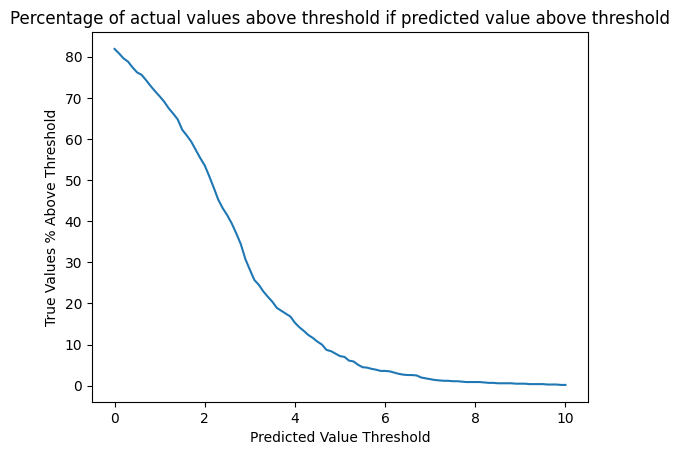

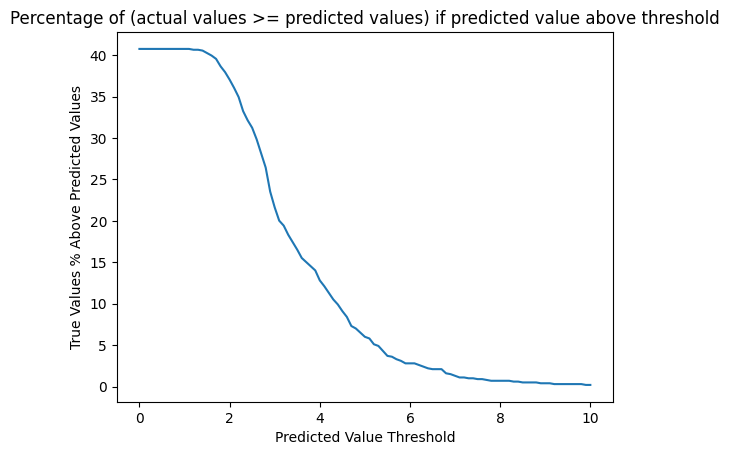

In [53]:
actual_vs_thresh_prob = []
x = np.linspace(0, 10, 101)
for prediction_threshold in x:
    # what percentage of predicted_values above prediction_threshold had an actual_value above prediction_threshold
    actual_vs_thresh_prob.append(100 * ((actual_values > prediction_threshold * 1.0) & (predicted_values > 
                                                                              prediction_threshold)).mean())

plt.plot(x, actual_vs_thresh_prob)
plt.title('Percentage of actual values above threshold if predicted value above threshold')
plt.xlabel('Predicted Value Threshold')
plt.ylabel('True Values % Above Threshold')
plt.show()

actual_vs_pred_prob = []
# x = np.linspace(0, 10, 51)
for prediction_threshold in x:
    # what percentage of predicted_values above prediction_threshold had an actual_value above prediction_threshold
    actual_vs_pred_prob.append(100 * ((actual_values >= predicted_values) & (predicted_values > 
                                                                              prediction_threshold)).mean())

plt.plot(x, actual_vs_pred_prob)
plt.title('Percentage of (actual values >= predicted values) if predicted value above threshold')
plt.xlabel('Predicted Value Threshold')
plt.ylabel('True Values % Above Predicted Values')
plt.show()

In [54]:
x[find_first_below_threshold(actual_vs_thresh_prob, 50)]

2.2

In [47]:

# Use MSLE to penalize underestimates...need to modify to penalize overestimates
# Ensure that neither actual_values nor predicted_values contain negative values
actual_values_adj = np.maximum((1 + actual_values/100), 0)
predicted_values_adj = np.maximum((1 + predicted_values/100), 0)
# Swap the actual and predicted values to punish overestimates.
modified_msle = mean_squared_log_error(predicted_values_adj, actual_values_adj)

print("Mean Squared Logarithmic Error:", modified_msle)
"Mean Squared Logarithmic Error: 0.0003165310587558688"

Mean Squared Logarithmic Error: 0.00031980676216002824


'Mean Squared Logarithmic Error: 0.0003165310587558688'

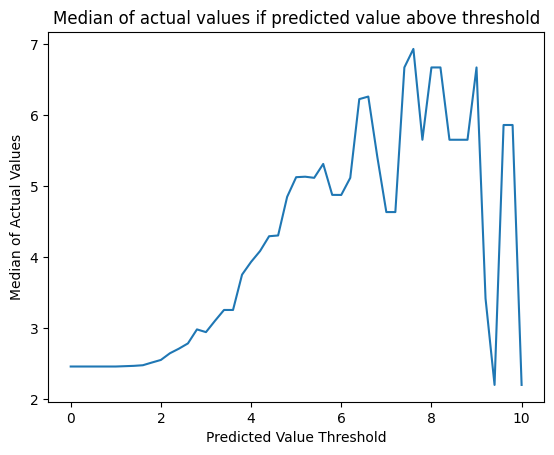

In [68]:
y = []
x = np.linspace(0, 10, 51)
for prediction_threshold in x:
    y.append(np.median(actual_values[predicted_values >= prediction_threshold]))
plt.plot(x, y)
plt.title('Median of actual values if predicted value above threshold')
plt.xlabel('Predicted Value Threshold')
plt.ylabel('Median of Actual Values')
plt.show()

In [62]:
actual_values[predicted_values >= prediction_threshold]

array([-1.96941127,  2.19725838,  9.53086672, -4.08937605, 12.43659476,
       12.24781457,  1.59481011])